In [1]:
import Pkg
Pkg.activate(".")

  Activating project at `C:\Users\asus`


In [40]:
Pkg.add(["ADTypes", "MLUtils", "Optimisers", "OneHotArrays", "Random", "Statistics", "Printf", "MLDatasets","Images", "Plots","CairoMakie","LinearAlgebra","Distributions","Convex","SCS","StatsBase","StatsPlots"])

   Resolving package versions...
  No Changes to `C:\Users\asus\Project.toml`
  No Changes to `C:\Users\asus\Manifest.toml`


In [41]:
using ADTypes, MLUtils, Optimisers, OneHotArrays, Random, Statistics, Printf, Images, LinearAlgebra, Plots, CairoMakie, Distributions, Convex, SCS, StatsBase, StatsPlots
using MLDatasets: MNIST

In [182]:
N = 1000 # choosing smaller dataset
dataset = MNIST(; split=:train)
imgs = dataset.features[:, :, 1:N]
labels_raw = dataset.targets[1:N]
B = onehotbatch(labels_raw, 0:9)' # each row is a data and columns are labels
A = reshape(imgs, :, size(imgs, 3))' # flatten version - each row is a data and column is a pixel
display(B)

60000×10 adjoint(OneHotMatrix(::Vector{UInt32})) with eltype Bool:
 ⋅  ⋅  ⋅  ⋅  ⋅  1  ⋅  ⋅  ⋅  ⋅
 1  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅
 ⋅  ⋅  ⋅  ⋅  1  ⋅  ⋅  ⋅  ⋅  ⋅
 ⋅  1  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅
 ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  1
 ⋅  ⋅  1  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅
 ⋅  1  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅
 ⋅  ⋅  ⋅  1  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅
 ⋅  1  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅
 ⋅  ⋅  ⋅  ⋅  1  ⋅  ⋅  ⋅  ⋅  ⋅
 ⋅  ⋅  ⋅  1  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅
 ⋅  ⋅  ⋅  ⋅  ⋅  1  ⋅  ⋅  ⋅  ⋅
 ⋅  ⋅  ⋅  1  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅
 ⋮              ⋮           
 ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  1  ⋅  ⋅
 ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  1  ⋅
 ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  1
 ⋅  ⋅  1  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅
 ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  1
 ⋅  ⋅  ⋅  ⋅  ⋅  1  ⋅  ⋅  ⋅  ⋅
 ⋅  1  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅
 ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  1  ⋅
 ⋅  ⋅  ⋅  1  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅
 ⋅  ⋅  ⋅  ⋅  ⋅  1  ⋅  ⋅  ⋅  ⋅
 ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  1  ⋅  ⋅  ⋅
 ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  1  ⋅

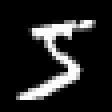

In [183]:
Gray.(imgs[:,:,1]') # an example of a data

In [184]:
function lasso(A, B, λ1)
    (T, K, F) = (size(A, 1), size(A, 2), size(B,2))
    Q = A'A / T
    c = A'B / T                      #c'b = Y'X*b

    x = Variable(K, F)              #define variables to optimize over
    L1 = quadform(x, Q; assume_psd=true)            #b'Q*b
    L2 = dot(c, x)                 #c'b
    L3 = norm(x, 1)                #sum(|b|)

    problem = minimize(L1 - 2 * L2 + λ1 * L3)
    solve!(problem, SCS.Optimizer; silent = true)
    return x.value
end

lasso (generic function with 1 method)

In [197]:
λ=[0.01 0.1 1 10 100]
acc_vec = []
for k in 1:length(λ)
    train_split = 0.8
    (A_train, B_train), (A_test, B_test) = splitobs((A', B'); at=train_split)
    x = lasso(A_train', B_train', λ[k])
    y = A_test' * x
    # converting y into one-hot-code based on its max values
    y_max_idx=vec(argmax(y, dims=2))
    num_classes = 10     # Number of one-hot columns
    N_test = Int(round((1-train_split)*N))
    B_pred = zeros(Float32, N_test, num_classes)
    for i in 1:N_test
        B_pred[y_max_idx[i,1]] = 1
    end
    accuracy = sum(B_pred .== B_test')/length(B_test) * 100
    push!(acc_vec, accuracy)
end


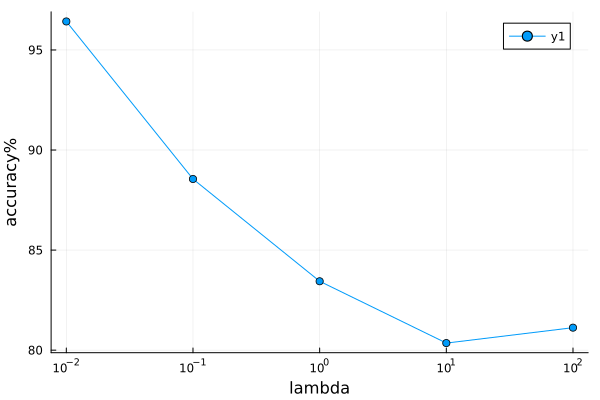

In [203]:
Plots.plot(vec(λ), acc_vec, xlabel="lambda", ylabel="accuracy%", marker=:circle, xscale=:log10)

In [205]:
N = 60000 # full dataset
dataset = MNIST(; split=:train)
imgs = dataset.features[:, :, 1:N]
labels_raw = dataset.targets[1:N]
B = onehotbatch(labels_raw, 0:9)' # each row is a data and columns are labels
A = reshape(imgs, :, size(imgs, 3))' # flatten version - each row is a data and column is a pixel
λ=0.01
train_split = 0.8
(A_train, B_train), (A_test, B_test) = splitobs((A', B'); at=train_split)
x = lasso(A_train', B_train', λ)
y = A_test' * x
# converting y into one-hot-code based on its max values
y_max_idx=vec(argmax(y, dims=2))
num_classes = 10     # Number of one-hot columns
N_test = Int(round((1-train_split)*N))
B_pred = zeros(Float32, N_test, num_classes)
for i in 1:N_test
    B_pred[y_max_idx[i,1]] = 1
end
accuracy = sum(B_pred .== B_test')/length(B_test) * 100

96.42333333333333

In [206]:
# normalizing x
x = x/maximum(x)
# reshaping
x = reshape(x, size(imgs,1), size(imgs,2), size(x,2))

28×28×10 Array{Float64, 3}:
[:, :, 1] =
  5.01233e-16   2.8804e-24    2.65469e-19  …   2.12042e-12   1.18882e-11
  5.01233e-16  -2.98712e-23   4.45459e-17      7.13994e-13   4.57784e-11
  5.01233e-16  -2.17409e-22  -4.57719e-10     -1.37901e-12  -9.46331e-12
  5.01233e-16   3.01174e-22   2.71731e-10     -8.63983e-11  -2.0879e-12
  5.01233e-16   3.95232e-12   4.15174e-10     -4.92984e-9   -1.16831e-9
  5.01233e-16  -1.23277e-10  -9.5353e-10   …  -4.28622e-9   -3.03022e-9
  5.01233e-16  -4.97618e-9   -2.38879e-8       6.02808e-9    2.41299e-10
  5.01233e-16  -8.80429e-9   -5.30858e-8      -2.00169e-8   -9.75548e-10
  5.01233e-16  -1.17592e-8   -7.7169e-8       -5.215e-8      2.59869e-9
  5.01233e-16  -1.76629e-8   -1.04162e-7      -4.15236e-8    3.85464e-9
  5.01233e-16  -1.90983e-8   -1.76503e-7   …  -1.07876e-7   -1.85416e-8
  5.01233e-16  -2.61694e-8   -3.12632e-7      -2.0399e-7    -3.58601e-8
 -1.55758e-10  -4.52873e-8   -4.74856e-7      -2.79103e-7   -2.48866e-8
  ⋮                

In [209]:
ximg = zeros(size(imgs,1)*2, size(imgs,2)*5)
n = [1 2 3 4 5;6 7 8 9 10]
for i in 1:2
    for j in 1:5
        ximg[size(imgs,1)*(i-1)+1:size(imgs,1)*i,size(imgs,2)*(j-1)+1:size(imgs,2)*j] = x[:,:, n[i,j]]'
    end
end

LoadError: DimensionMismatch: mismatch in dimension 1 (expected 1 got 2)

In [212]:
n = [1 2 3 4 5;6 7 8 9 10]

2×5 Matrix{Int64}:
 1  2  3  4   5
 6  7  8  9  10

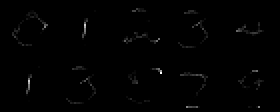

In [208]:
Gray.(ximg)

In [167]:
Gray.(ximg)

28×28×10 Array{Float64, 3}:
[:, :, 1] =
 5.94842e-10   5.94842e-10  -3.27224e-29  …   5.49687e-10  -8.04037e-10
 5.94842e-10   5.94842e-10   1.4105e-28       6.45763e-10  -9.99305e-10
 5.94842e-10   5.94842e-10   4.50281e-28      1.59378e-9   -1.26288e-10
 5.94842e-10   5.94842e-10  -1.25923e-28     -0.000189507  -1.0833e-10
 5.94842e-10   5.94842e-10   1.47109e-28     -0.00200613   -2.19377e-10
 5.94842e-10   5.94842e-10  -2.08107e-28  …  -0.00385782    0.00139659
 5.94842e-10   5.94842e-10  -3.65338e-28      0.0045861     0.00224854
 5.94842e-10   5.94842e-10   4.04258e-28      0.0124888     0.00225775
 5.94842e-10   5.94842e-10   3.96644e-29      0.0183999     0.00177504
 5.94842e-10   5.94842e-10   3.42724e-28      0.0359606    -3.14232e-8
 5.94842e-10   0.0002031     0.00167558   …   0.0430716     0.000197144
 5.94842e-10   0.00125922    0.00439806       0.0300313     0.00333472
 5.94842e-10  -1.18961e-41   0.00291846       0.0214432     0.0039254
 ⋮                               

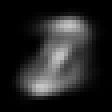